STEP 1: Extract Useful data and generate labels

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

bearings = {
    '35Hz12kN': ['Bearing1_1', 'Bearing1_2', 'Bearing1_3', 'Bearing1_4', 'Bearing1_5'],
    '37.5Hz11kN': ['Bearing2_1', 'Bearing2_2', 'Bearing2_3', 'Bearing2_4', 'Bearing2_5'],
    '40Hz10kN': ['Bearing3_1', 'Bearing3_2', 'Bearing3_3', 'Bearing3_4', 'Bearing3_5']
}

data_dir = os.path.join(os.getcwd(), 'data')
save_dir = os.path.join(os.getcwd(), 'extracted_data')

dataframes = {}
rul_labels = {}

for folder, bearings_list in bearings.items():
    folder_path = os.path.join(data_dir, folder)

    for bearing in bearings_list:
        bearing_path = os.path.join(folder_path, bearing)

        data_files = [os.path.join(bearing_path, f) for f in os.listdir(bearing_path) if f.endswith('.csv')]
        
        if data_files:
            try:
                data_files.sort()
                
                bearing_df = pd.concat([pd.read_csv(data_file) for data_file in data_files], ignore_index=True)
                dataframes[bearing] = bearing_df
                num_files = len(data_files)
                
                bearing_rul_labels = []

                for i, data_file in enumerate(data_files):
                    current_rul = num_files - i
                    samples_in_file = len(pd.read_csv(data_file))
                    
                    rul_for_file = np.full(samples_in_file, current_rul)
                    bearing_rul_labels.extend(rul_for_file)
                
                rul_labels[bearing] = bearing_rul_labels
                time_column = np.linspace(0, 60 * len(data_files), len(bearing_df), endpoint=False)  # Time in seconds
                bearing_df['Time'] = time_column
                bearing_df['RUL'] = bearing_rul_labels[:len(bearing_df)]

                # Save DataFrame to CSV
                bearing_df.to_csv(f'{save_dir}/{bearing}_with_labels.csv', index=False)
                print(f"CSV file created for: {bearing}")

            except Exception as e:
                print(f"Error reading files for {bearing}: {e}")
        else:
            print(f"No CSV files found for {bearing} in {bearing_path}")


CSV file created for: Bearing1_1
CSV file created for: Bearing1_2
CSV file created for: Bearing1_3
CSV file created for: Bearing1_4
CSV file created for: Bearing1_5
CSV file created for: Bearing1_6
CSV file created for: Bearing1_7
CSV file created for: Bearing2_1
CSV file created for: Bearing2_2
CSV file created for: Bearing2_3
CSV file created for: Bearing2_4
CSV file created for: Bearing2_5
CSV file created for: Bearing2_6
CSV file created for: Bearing2_7
CSV file created for: Bearing3_1
CSV file created for: Bearing3_2
CSV file created for: Bearing3_3


STEP 2: Visualize Data

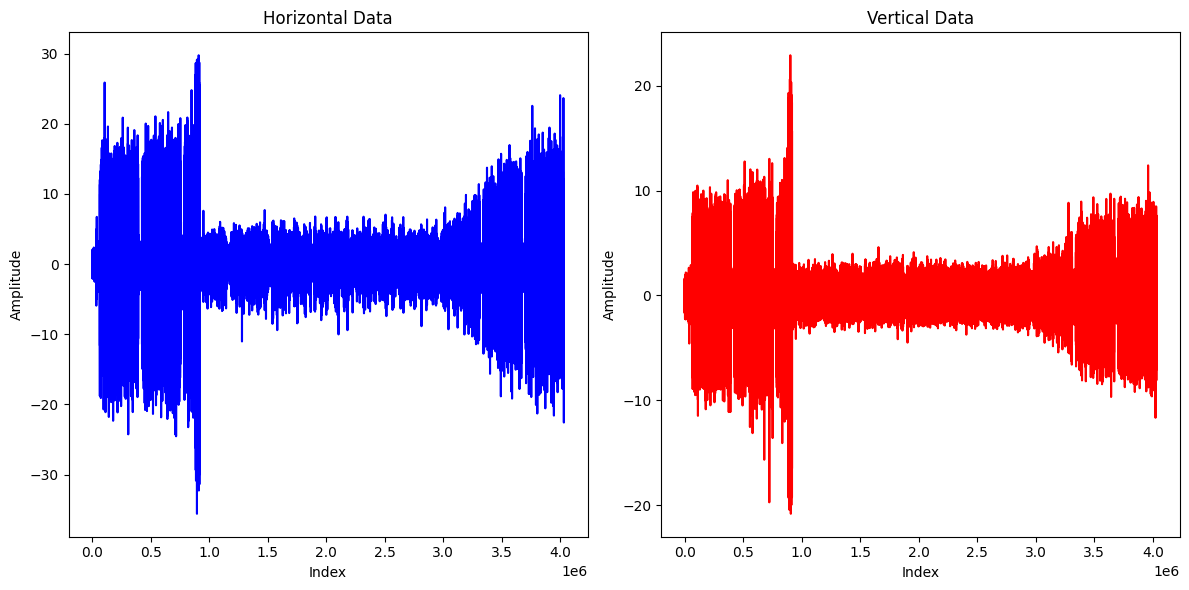

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

bearing = 'Bearing1_1'
save_dir = 'extracted_data'

df = pd.read_csv(f'{save_dir}/{bearing}_with_labels.csv')

horizontal_data = df['Horizontal_vibration_signals'].values
vertical_data = df['Vertical_vibration_signals'].values

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(horizontal_data, color='blue')
ax1.set_title('Horizontal Data')
ax1.set_xlabel('Index')
ax1.set_ylabel('Amplitude')

ax2.plot(vertical_data, color='red')
ax2.set_title('Vertical Data')
ax2.set_xlabel('Index')
ax2.set_ylabel('Amplitude')

plt.tight_layout()
plt.show()


STEP 5: Extract TF features via Wavelet Transform

In [ ]:
import os
import pandas as pd
import numpy as np
import pywt
from scipy.stats import entropy, kurtosis, skew


bearings = {'Bearing1_1', 'Bearing1_2', 'Bearing1_3', 'Bearing1_4', 'Bearing1_5',
            'Bearing2_1', 'Bearing2_2', 'Bearing2_3', 'Bearing2_4', 'Bearing2_5', 
            'Bearing3_1', 'Bearing3_2', 'Bearing3_3', 'Bearing3_4', 'Bearing3_5' }


input_folder = 'filter_data'
output_folder = 'tf_features_mm'

# Signal specifications
fs = 25600  # Sampling frequency (Hz)
delta_t = 1 / fs  # Sampling interval (s)
f_min = 10  # Minimum frequency of interest (Hz)
f_max = 120  # Maximum frequency of interest (Hz)
f_c = 0.81  # Central frequency of Morlet wavelet

# Calculate scale limits
s_min = f_c / (f_max * delta_t)
s_max = f_c / (f_min * delta_t)

# Generate scales
num_scales = 100
scales = np.logspace(np.log10(s_min), np.log10(s_max), num_scales)

for bearing in bearings:

    df = pd.read_csv(f'{input_folder}/Smooth_{bearing}.csv')

    signalARms = df['Horizontal'].values
    signalBRms = df['Vertical'].values
    rul = df['RUL'].values

    wavelet = 'cmor'

    window_size = 1000
    step_size = 500

    # Prepare DataFrame
    data = []

    for start in range(0, len(signalARms) - window_size, step_size):
        window_signal1 = signalARms[start:start + window_size]
        window_signal2 = signalBRms[start:start + window_size]
        
        coeff1, freq1 = pywt.cwt(window_signal1, scales, wavelet, sampling_period=1/fs)
        coeff2, freq2 = pywt.cwt(window_signal2, scales, wavelet, sampling_period=1/fs)
        
        # Energy: Sum of squared coefficients
        energy1 = np.sum(np.abs(coeff1) ** 2)
        energy2 = np.sum(np.abs(coeff2) ** 2)
        
        # Dominant frequency: Scale with maximum energy
        dominant_scale1 = np.argmax(np.sum(np.abs(coeff1) ** 2, axis=1))
        dominant_scale2 = np.argmax(np.sum(np.abs(coeff2) ** 2, axis=1))
        dominant_frequency1 = freq1[dominant_scale1]
        dominant_frequency2 = freq2[dominant_scale2]
        
        # Entropy: Shannon entropy of the signal
        def calculate_entropy(signal):
            hist, bins = np.histogram(signal, bins=3, density=True)
            return entropy(hist + 1e-9)
        
        entropy1 = calculate_entropy(window_signal1)
        entropy2 = calculate_entropy(window_signal2)
        
        # Kurtosis and skewness
        kurtosis1 = kurtosis(window_signal1)
        kurtosis2 = kurtosis(window_signal2)
        skewness1 = skew(window_signal1)
        skewness2 = skew(window_signal2)
        
        # Mean and standard deviation
        mean1 = np.mean(window_signal1)
        mean2 = np.mean(window_signal2)
        std1 = np.std(window_signal1)
        std2 = np.std(window_signal2)
        
        # Feature vectors
        feature_vector1 = [energy1, dominant_frequency1, entropy1, kurtosis1, skewness1, mean1, std1]
        feature_vector2 = [energy2, dominant_frequency2, entropy2, kurtosis2, skewness2, mean2, std2]
        
        # RUL label
        center_index = start + window_size // 2
        rul_label = rul[center_index]
        
        # Append data row
        data.append({
            'Horizontal': feature_vector1,
            'Vertical': feature_vector2,
            'RUL': rul_label
        })

    # Convert to DataFrame
    df_features = pd.DataFrame(data)

    # Save to CSV
    output_file = f'{output_folder}/{bearing}_features.csv'
    df_features.to_csv(output_file, index=False)

    print(f"Features saved to {output_file}")


/home/ustc15/.local/lib/python3.10/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should follow the format cmorB-C, where B and C are floats representing the bandwidth frequency and center frequency, respectively (example, for backward compatibility: cmor = cmor1.0-0.5).
  wavelet = DiscreteContinuousWavelet(wavelet)


Features saved to tf_features/Bearing1_1_features.csv


STEP 6: Visualize TF features

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils.preprocess import process_features



dfs = []
for i in range(1, 6):
    dfs.append(pd.read_csv(f'/home/ustc15/research/idea2/time_features/Bearing1_{i}_features_with_labels.csv'))

# Combine RUL arrays
rul = np.hstack([df['RUL'].values for df in dfs])
maxx = np.max(rul)
rul = rul / maxx

# Extract and process the 'Horizontal' columns
horizontal_data = [np.array(df['Horizontal'].apply(eval).tolist()) for df in dfs]

# Process features for horizontal data
processed_features = [process_features(data) for data in horizontal_data]

# Combine full feature sets
features_array_horizontal = np.vstack(processed_features)

# Select the first DataFrame
df = dfs[0]

# Extract and process the 'Horizontal' column
horizontal_data = np.array(df['Vertical'].apply(eval).tolist())

# Process features for horizontal data
processed_features = process_features(horizontal_data)

# Plotting the features
feature_names = [r"$E_{v}$", r"$f_{d_{v}}$", r"$h_{v}$", r"$k_{v}$", r"$sk_{v}$", r"$avg_{v}$", r"$\sigma_{v}$"]
num_features = processed_features.shape[1]
colors = plt.cm.inferno(np.linspace(0, 1, num_features))  # Reverting to the vibrant color palette

plt.figure(figsize=(13, 7))  # More compact image
# plt.style.use('seaborn-v0_8-deep')
for i in range(num_features):
    plt.subplot(num_features, 1, i+1)
    plt.grid()
    plt.plot(processed_features[:, i], label=feature_names[i], color=colors[i])
    plt.ylabel(feature_names[i])
    if i == num_features - 1:
        plt.xlabel('Frequency(Hz)')  # Only add x-axis label on the last subplot
    else:
        plt.xticks([])  # Hide x-ticks for all plots except the last one
    plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


Convert Signal to Images

In [3]:
import os
import pandas as pd
import numpy as np
from bresenham import bresenham
from PIL import Image
from tqdm import tqdm  # For progress tracking

# Define the folder structure for your data
bearings = {
    '35Hz12kN': ['Bearing1_1', 'Bearing1_2', 'Bearing1_3', 'Bearing1_4', 'Bearing1_5'],
    '37.5Hz11kN': ['Bearing2_1', 'Bearing2_2', 'Bearing2_3', 'Bearing2_4', 'Bearing2_5'],
    '40Hz10kN': ['Bearing3_1', 'Bearing3_2', 'Bearing3_3', 'Bearing3_4', 'Bearing3_5']
}

data_dir = os.path.join(os.getcwd(), 'extracted_data')
output_dir = os.path.join(os.getcwd(), 'bearing_images')

# Parameters for signal-to-image conversion
resolution = 0.015625  # 64/1000
dummy = 1
window_size = 1000
stride = 500

# Create output directories
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Normalize data between 0 and 1
def normalize_signal(signal):
    min_val = np.min(signal)
    max_val = np.max(signal)
    return (signal - min_val) / (max_val - min_val)

for folder, bearings_list in bearings.items():
    folder_path = os.path.join(data_dir, folder)

    for bearing in bearings_list:
        bearing_path = os.path.join(data_dir, f"{bearing}_with_labels.csv")

        # Check if the file exists
        if os.path.exists(bearing_path):
            # Load data
            bearing_df = pd.read_csv(bearing_path)

            # Prepare output folders
            bearing_dir = os.path.join(output_dir, bearing)
            horizontal_dir = os.path.join(bearing_dir, "Horizontal")
            vertical_dir = os.path.join(bearing_dir, "Vertical")
            os.makedirs(horizontal_dir, exist_ok=True)
            os.makedirs(vertical_dir, exist_ok=True)

            # Windowing the signals
            horizontal_signal = bearing_df['Horizontal_vibration_signals'].values
            vertical_signal = bearing_df['Vertical_vibration_signals'].values

            # Normalize the signals before windowing
            horizontal_signal = normalize_signal(horizontal_signal)
            vertical_signal = normalize_signal(vertical_signal)

            horizontal_windows = []
            vertical_windows = []

            for start in range(0, len(horizontal_signal) - window_size + 1, stride):
                horizontal_windows.append(horizontal_signal[start:start + window_size])
                vertical_windows.append(vertical_signal[start:start + window_size])

            # Convert horizontal signals to images
            print(f"Processing horizontal images for {bearing}...")
            for idx, window in tqdm(enumerate(horizontal_windows), total=len(horizontal_windows)):
                y1 = np.searchsorted(np.arange(0, 1 + resolution, resolution), window[:-1]) - 1
                y2 = np.searchsorted(np.arange(0, 1 + resolution, resolution), window[1:]) - 1
                pairs = list(zip(
                    np.arange(0, len(window) * dummy, dummy)[:-1], y1,
                    np.arange(dummy, len(window) * dummy + 1, dummy)[:-1], y2
                ))

                # Create an image using Bresenham's line algorithm
                img_x_ax = np.arange(0, len(window) * dummy)
                img_y_ax = np.arange(0, 1 + resolution, resolution)
                zeros = np.zeros((len(img_y_ax), len(img_x_ax)))
                for pair in pairs:
                    x0, y0, x1, y1 = pair
                    bresenham_output = list(bresenham(x0, y0, x1, y1))
                    img_x, img_y = zip(*bresenham_output)
                    zeros[img_y, img_x] = 255

                # Save the image
                img_path = os.path.join(horizontal_dir, f"window_{idx}.png")
                Image.fromarray(np.flipud(zeros)).convert("L").save(img_path, optimize=True, quality=95)

        else:
            print(f"No CSV file found for {bearing} in {folder_path}")

Processing horizontal images for Bearing1_1...


 10%|▉         | 781/8059 [00:07<01:22, 88.61it/s] 

100%|██████████| 8059/8059 [01:05<00:00, 122.40it/s]


Processing horizontal images for Bearing1_2...


100%|██████████| 10550/10550 [01:31<00:00, 115.22it/s]


Processing horizontal images for Bearing1_3...


100%|██████████| 10353/10353 [01:17<00:00, 133.37it/s]


Processing horizontal images for Bearing1_4...


100%|██████████| 7994/7994 [00:47<00:00, 167.08it/s]


Processing horizontal images for Bearing1_5...


100%|██████████| 3406/3406 [00:27<00:00, 124.96it/s]


Processing horizontal images for Bearing2_1...


100%|██████████| 32177/32177 [03:11<00:00, 168.38it/s]


Processing horizontal images for Bearing2_2...


100%|██████████| 10550/10550 [01:28<00:00, 119.28it/s]


Processing horizontal images for Bearing2_3...


100%|██████████| 34929/34929 [04:43<00:00, 123.20it/s]


Processing horizontal images for Bearing2_4...


100%|██████████| 2751/2751 [00:23<00:00, 118.05it/s]


Processing horizontal images for Bearing2_5...


100%|██████████| 22215/22215 [03:25<00:00, 108.09it/s]


Processing horizontal images for Bearing3_1...


100%|██████████| 166329/166329 [16:40<00:00, 166.29it/s]


Processing horizontal images for Bearing3_2...


100%|██████████| 95681/95681 [15:00<00:00, 106.22it/s]


Processing horizontal images for Bearing3_3...


100%|██████████| 24312/24312 [02:46<00:00, 145.92it/s]


Processing horizontal images for Bearing3_4...


100%|██████████| 99286/99286 [10:30<00:00, 157.37it/s]


Processing horizontal images for Bearing3_5...


100%|██████████| 7470/7470 [01:27<00:00, 85.21it/s] 


In [1]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

# Parameters
image_size = (500, 63)  # Resize images to a standard size

# Paths
output_dir = os.path.join(os.getcwd(), 'bearing_images')
save_dir = os.path.join(os.getcwd(), 'image_features')

# Bearings to process
bearings = ['Bearing1_1','Bearing1_2', 'Bearing1_3', 'Bearing1_4', 'Bearing1_5',
            'Bearing2_1', 'Bearing2_2', 'Bearing2_3', 'Bearing2_4', 'Bearing2_5']

# Function to load images
def load_images(output_dir, save_dir, bearings, resize_to=image_size):
    images_horizontal = []

    for bearing in tqdm(bearings, desc="Processing Bearings"):
        bearing_path = os.path.join(output_dir, bearing)
        if os.path.isdir(bearing_path):
            # Paths for horizontal subdirectory
            horizontal_dir = os.path.join(bearing_path, "Horizontal")

            # Process horizontal images
            if os.path.isdir(horizontal_dir):
                for img_file in tqdm(os.listdir(horizontal_dir), desc=f"Processing Horizontal for {bearing}", leave=False):
                    if img_file.endswith('.png'):
                        try:
                            # Load and preprocess image
                            img_path = os.path.join(horizontal_dir, img_file)
                            img = Image.open(img_path).resize(resize_to, Image.LANCZOS)
                            img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]

                            images_horizontal.append(img_array)
                        except Exception as e:
                            print(f"Error processing file {img_file}: {e}")

                # Save horizontal images separately for each bearing
                bearing_horizontal_images = np.array(images_horizontal)
                np.save(f'{save_dir}/{bearing}_horizontal_images.npy', bearing_horizontal_images)

                # Reset list for next bearing
                images_horizontal = []

    return np.array(images_horizontal)

# Load data
horizontal_data = load_images(output_dir, save_dir, bearings)

Processing Bearings: 100%|██████████| 10/10 [07:25<00:00, 44.54s/it]


STEP 7: Visualize RUL 

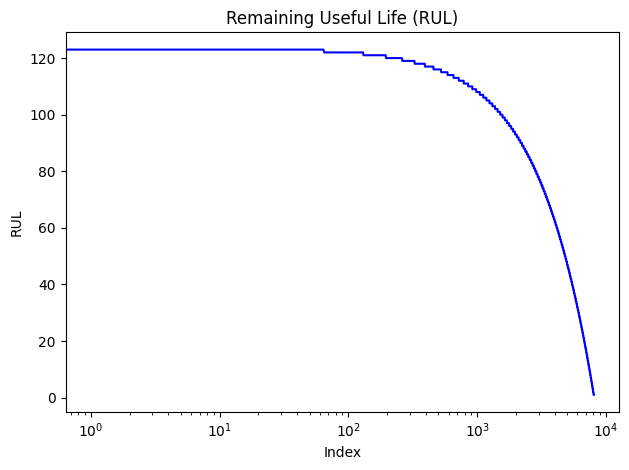

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

bearing = 'Bearing1_1'
data_dir = 'tf_features_mm'

df = pd.read_csv(f'{data_dir}/{bearing}_features.csv')

rul = df['RUL'].values

plt.plot(rul, color='blue')
plt.title('Remaining Useful Life (RUL)')
plt.xlabel('Index')
plt.xscale('log')
plt.ylabel('RUL')
plt.tight_layout()
plt.show()

STEP 4: Train Multimodal

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from keras._tf_keras.keras.models import Model
from sklearn.model_selection import KFold
from keras._tf_keras.keras.regularizers import l2
from utils.reset_callback import ResetStatesCallback
from utils.multimod_datagen import MultimodalDataGen
from utils.preprocess import process_features,correct_dims3
from keras._tf_keras.keras.optimizers import RMSprop
from keras._tf_keras.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras._tf_keras.keras.layers import Input, Conv1D, Dense, Concatenate, Conv2D, BatchNormalization, Activation, GlobalMaxPooling1D, LayerNormalization, MultiHeadAttention, Add, Reshape, Lambda, MaxPooling2D, LSTM, MaxPooling1D


#load_directories
dir = os.getcwd()
image_dir = os.path.join(dir,'image_features')
time_dir = os.path.join(dir,'tf_features_mm')
weights_dir = os.path.join(dir,'model_weights')
stat_dir = os.path.join(dir,'statistics')

#loading_data
bearings = ['Bearing1_1','Bearing1_2','Bearing1_4']

X_visual = np.vstack([np.load(f'{image_dir}/{bearing}_horizontal_images.npy', allow_pickle=True) for bearing in bearings])
X_visual = np.array([correct_dims3(img) for img in X_visual]) 

dfs = [pd.read_csv(f'{time_dir}/{bearing}_features.csv') for bearing in sorted(bearings)]
y = np.concatenate([df['RUL'].values / np.max(df['RUL'].values) for df in dfs])
vertical_data = [np.array(df['Vertical'].apply(eval).tolist()) for df in dfs]
X_time = np.vstack([process_features(data) for data in vertical_data])
X_time = np.array([correct_dims3(data) for data in X_time])


#input_shapes
img_shape = np.shape(X_visual[0])
time_shape = np.shape(X_time[0])

print(f'Image shape: {img_shape}')

reg_strength = 0.01

# Image Branch
img_shape = (63,500, 1)
img_input = Input(shape=img_shape)
img_conv1 = Conv2D(32, (5, 5), padding='same', dilation_rate=(4, 4), kernel_regularizer=l2(reg_strength))(img_input)
img_conv1 = BatchNormalization()(img_conv1)
img_conv1 = Activation('relu')(img_conv1)
img_conv1 = MaxPooling2D((3, 3), padding='same')(img_conv1)

img_conv2 = Conv2D(32, (3, 3), padding='same', dilation_rate=(3, 3), kernel_regularizer=l2(reg_strength))(img_conv1)
img_conv2 = BatchNormalization()(img_conv2)
img_conv2 = Activation('relu')(img_conv2)
img_conv2 = MaxPooling2D((3, 3), name='ires1ip', padding='same')(img_conv2)

img_res1 = Conv2D(32, (1, 1), padding='same', kernel_regularizer=l2(reg_strength))(img_input)
img_res1 = Lambda(lambda x: tf.image.resize(x, (img_conv2.shape[1], img_conv2.shape[2])))(img_res1)
img_res1 = Add(name='ires1')([img_res1, img_conv2])

img_conv3 = Conv2D(64, (3, 3), padding='same', dilation_rate=(2, 2), kernel_regularizer=l2(reg_strength))(img_res1)
img_conv3 = BatchNormalization()(img_conv3)
img_conv3 = Activation('relu')(img_conv3)
img_conv3 = MaxPooling2D((3, 3), padding='same')(img_conv3)

img_conv4 = Conv2D(64, (2, 2), padding='same', dilation_rate=(1, 1), kernel_regularizer=l2(reg_strength))(img_conv3)
img_conv4 = BatchNormalization()(img_conv4)
img_conv4 = Activation('relu')(img_conv4)
img_conv4 = MaxPooling2D((2, 2), name='ires2ip', padding='same')(img_conv4)

img_res2 = Conv2D(64, (1, 1), padding='same', kernel_regularizer=l2(reg_strength))(img_res1)
img_res2 = Lambda(lambda x: tf.image.resize(x, (img_conv4.shape[1], img_conv4.shape[2])))(img_res2)
img_res2 = Add(name='ires2')([img_res2, img_conv4])
img_output = Reshape((-1, int(img_res2.shape[-1])))(img_res2)

# Time Branch
time_shape = (7, 1)
time_input = Input(shape=time_shape)
time_conv1 = Conv1D(32, 2, padding='same', dilation_rate=2, kernel_regularizer=l2(reg_strength))(time_input)
time_conv1 = BatchNormalization()(time_conv1)
time_conv1 = Activation('relu')(time_conv1)
time_conv1 = MaxPooling1D(pool_size=1)(time_conv1)

time_conv2 = Conv1D(32, 2, padding='same', dilation_rate=2, kernel_regularizer=l2(reg_strength))(time_conv1)
time_conv2 = BatchNormalization()(time_conv2)
time_conv2 = Activation('relu')(time_conv2)
time_conv2 = MaxPooling1D(pool_size=1, name='tres1ip')(time_conv2)

time_res1 = Conv1D(32, 1, padding='same', kernel_regularizer=l2(reg_strength))(time_input)
time_res1 = Add(name='tres1')([time_conv2, time_res1])

time_conv3 = Conv1D(64, 2, padding='same', dilation_rate=1, kernel_regularizer=l2(reg_strength))(time_res1)
time_conv3 = BatchNormalization()(time_conv3)
time_conv3 = Activation('relu')(time_conv3)
time_conv3 = MaxPooling1D(pool_size=1)(time_conv3)

time_conv4 = Conv1D(64, 2, padding='same', dilation_rate=1, kernel_regularizer=l2(reg_strength))(time_conv3)
time_conv4 = BatchNormalization()(time_conv4)
time_conv4 = Activation('relu')(time_conv4)
time_conv4 = MaxPooling1D(pool_size=1, name='tres2ip')(time_conv4)

time_res2 = Conv1D(64, 1, padding='same', kernel_regularizer=l2(reg_strength))(time_res1)
time_output = Add(name='tres2')([time_res2, time_conv4])

# Multimodal Model
concat = Concatenate(axis=1, name='mres1ip')([img_output, time_output])
lstm1 = LSTM(100, activation='tanh', return_sequences=True)(concat)
lstm2 = LSTM(64, activation='tanh', return_sequences=True)(lstm1)
lstm2 = LSTM(64, activation='tanh', return_sequences=True)(lstm2)
res_m = Add(name='mres1')([concat, lstm2])

norm_m = LayerNormalization()(res_m)
mha_m = MultiHeadAttention(num_heads=8, key_dim=64)(norm_m, norm_m, norm_m)
out_m = GlobalMaxPooling1D()(mha_m)
out_m = Dense(64, activation='relu', kernel_regularizer=l2(reg_strength))(out_m)
out_m = Dense(32, activation='relu', kernel_regularizer=l2(reg_strength))(out_m)
out_m = Dense(1)(out_m)

model = Model(inputs=[img_input, time_input], outputs=out_m)
model.compile(optimizer=RMSprop(learning_rate=1e-4), loss='mse', metrics=['mae'])


#callbacks
reset_states_callback = ResetStatesCallback()
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-10)
checkpoint_callback = ModelCheckpoint(f'{weights_dir}/xjtu_multimodal_weights.hdf5.keras', monitor='loss', save_best_only=True, mode='auto',save_weights_only=False)


K = 8
kf = KFold(n_splits=K, shuffle=True, random_state=42)
fold_no = 1


# Create an empty list to store all histories
all_histories = []

# Training loop for K-Folds
for train_idx, val_idx in kf.split(X_visual):
    print(f"\nTraining Fold {fold_no}/{K}")
    X_train_vis, X_val_vis = X_visual[train_idx], X_visual[val_idx]
    X_train_ts, X_val_ts = X_time[train_idx], X_time[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    train_gen = MultimodalDataGen(X_train_vis, X_train_ts, y_train, batch_size=32, augmentation=True)
    val_gen = MultimodalDataGen(X_val_vis, X_val_ts, y_val, batch_size=32, augmentation=False)

    history = model.fit(
        train_gen,
        epochs=5,
        batch_size=32,
        validation_data=val_gen,
        callbacks=[reduce_lr_callback, checkpoint_callback, reset_states_callback]
    )

    # Append history along with fold number
    for epoch in range(len(history.history['loss'])):
        all_histories.append({
            'Fold': fold_no,
            'Epoch': epoch + 1,
            'Loss': history.history['loss'][epoch],
            'Val_Loss': history.history['val_loss'][epoch],
        })
    
    fold_no += 1

# Create a DataFrame and save it as a CSV
df = pd.DataFrame(all_histories)
df.to_csv(f'{stat_dir}/xjtu_multimodal_training_history.csv', index=False)

2025-05-28 15:35:33.408321: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-28 15:35:33.467961: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-28 15:35:33.898182: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-28 15:35:34.118535: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748417734.514611   22782 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748417734.61

Image shape: (63, 500, 1)


W0000 00:00:1748417809.845719   22782 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...



Training Fold 1/2


/home/ustc15/anaconda3/envs/tf/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


631/631 ━━━━━━━━━━━━━━━━━━━━ 280s 433ms/step - loss: 3.8418 - mae: 0.1684 - val_loss: 1.7914 - val_mae: 0.1496

Training Fold 2/2
631/631 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - loss: 1.4298 - mae: 0.1088

: 

STEP 10: Visualize Training Statistics

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import csv
import os
import pandas as pd


# Read CSV file
dir = os.getcwd()
stats_dir = os.path.join(dir, 'statistics')

df = pd.read_csv(f'{stats_dir}/xjtu_multimodal_training_history.csv')

# Extract loss and validation loss
loss = df['loss'].values
val_loss = df['val_loss'].values
MAE = df['mae'].values
val_MAE = df['val_mae'].values
epochs = np.arange(1, len(loss) + 1)

plt.style.use('seaborn-v0_8-deep')
# Plot loss and validation loss
plt.plot(epochs, loss, label="RMSE", linestyle='-')
plt.plot(epochs, val_loss, label="Validation RMSE", linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("RMSE and Validation RMSE over Epochs (PRONOSTIA)")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(epochs, MAE, label="MAE", linestyle='-')
plt.plot(epochs, val_MAE, label="Validation MAE", linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("MAE and Validation MAE over Epochs (PRONOSTIA)")
plt.legend()
plt.grid(True)
plt.show()


STEP 11: Ensemble Training

In [ ]:
import numpy as np
import os
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from keras._tf_keras.keras.models import Model
import pickle
from utils.preprocess import process_features,correct_dims3
from multimodal import multimod_rul
from keras._tf_keras.keras.optimizers import RMSprop

np.random.seed(100)

#load_directories
dir = os.getcwd()
image_dir = os.path.join(dir,'image_features')
time_dir = os.path.join(dir,'tf_features_mm')
weights_dir = os.path.join(dir,'model_weights')

#loading_data
bearings = ['Bearing1_1',  'Bearing1_2', 'Bearing1_3', 'Bearing2_1', 'Bearing2_3']
            
X_visual = np.vstack([np.load(f'{image_dir}/{bearing}_horizontal_images.npy', allow_pickle=True) for bearing in bearings])
X_visual = np.array([correct_dims3(img) for img in X_visual])

dfs = [pd.read_csv(f'{time_dir}/{bearing}_features.csv') for bearing in sorted(bearings)]
y = np.concatenate([df['RUL'].values / np.max(df['RUL'].values) for df in dfs])
vertical_data = [np.array(df['Vertical'].apply(eval).tolist()) for df in dfs]
X_time = np.vstack([process_features(data) for data in vertical_data])
X_time = np.array([correct_dims3(data) for data in X_time])



model = multimod_rul()
model.load_weights(f'{weights_dir}/xjtu_multimodal_weights.hdf5.keras')
feature_extractor = Model(inputs=model.input, outputs=model.get_layer(index=-2).output)  # Change index to select the layer
X_train_features = feature_extractor.predict([X_visual,X_time])

regressor = RandomForestRegressor(n_estimators=800, random_state=42)
regressor.fit(X_train_features, y)

# save
with open(f'{weights_dir}/xjtu_multimodal_skl.pkl','wb') as f:
    pickle.dump(regressor,f)



2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step


STEP 12: Ablation experiments

2025-05-28 18:26:48.402462: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-28 18:26:48.403382: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-28 18:26:48.406657: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-28 18:26:48.413789: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748428008.425655   16182 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748428008.42

252/252 ━━━━━━━━━━━━━━━━━━━━ 31s 103ms/step
252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step
252/252 ━━━━━━━━━━━━━━━━━━━━ 25s 99ms/step
252/252 ━━━━━━━━━━━━━━━━━━━━ 25s 98ms/step
252/252 ━━━━━━━━━━━━━━━━━━━━ 26s 102ms/step
330/330 ━━━━━━━━━━━━━━━━━━━━ 33s 99ms/step
330/330 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step
330/330 ━━━━━━━━━━━━━━━━━━━━ 32s 97ms/step
330/330 ━━━━━━━━━━━━━━━━━━━━ 32s 96ms/step
330/330 ━━━━━━━━━━━━━━━━━━━━ 33s 99ms/step
324/324 ━━━━━━━━━━━━━━━━━━━━ 32s 99ms/step
324/324 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step
324/324 ━━━━━━━━━━━━━━━━━━━━ 31s 97ms/step
324/324 ━━━━━━━━━━━━━━━━━━━━ 31s 96ms/step
324/324 ━━━━━━━━━━━━━━━━━━━━ 32s 99ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 25s 99ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 24s 97ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 24s 96ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 25s 99ms/step
107/107 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step
107/107 ━━━

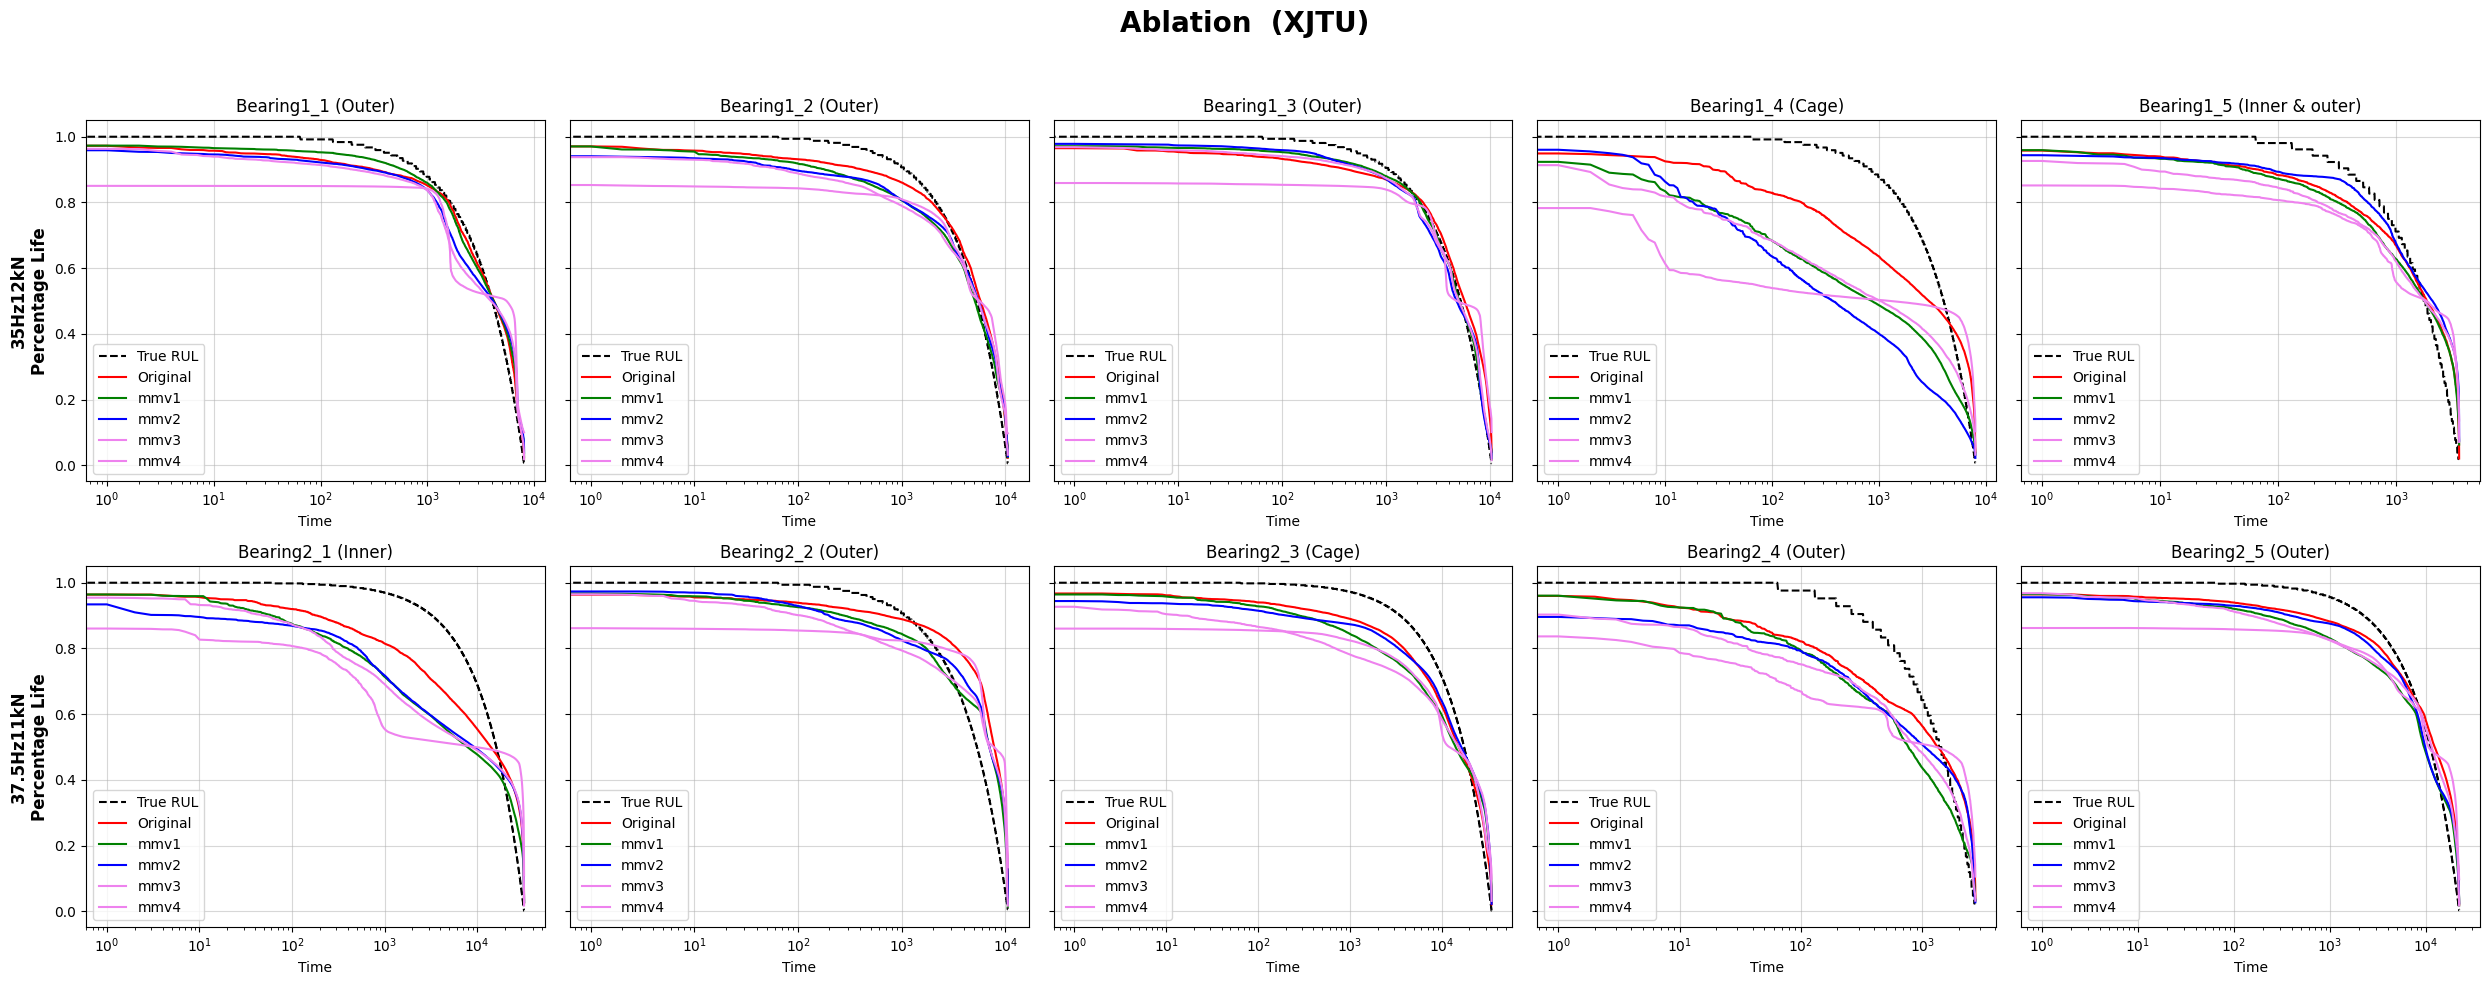

Idea 2: Ablation experiments results have been saved.csv


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras._tf_keras.keras.models import Model, load_model
from utils.preprocess import process_features,correct_dims3
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error
from multimodal import multimod_rul
from ablation_multimodal import mmv1,mmv2,mmv3


# Load directories
dir = os.getcwd()
time_dir = os.path.join(dir, 'tf_features_mm')
image_dir = os.path.join(dir, 'image_features')
weights_dir = os.path.join(dir, 'model_weights')
stats_dir = os.path.join(dir, 'statistics')

bearings = {
    '35Hz12kN': [
        {'name': 'Bearing1_1', 'failure': 'Outer'},
        {'name': 'Bearing1_2', 'failure': 'Outer'},
        {'name': 'Bearing1_3', 'failure': 'Outer'},
        {'name': 'Bearing1_4', 'failure': 'Cage'},
        {'name': 'Bearing1_5', 'failure': 'Inner & outer'},
    ],
    '37.5Hz11kN': [
        {'name': 'Bearing2_1', 'failure': 'Inner'},
        {'name': 'Bearing2_2', 'failure': 'Outer'},
        {'name': 'Bearing2_3', 'failure': 'Cage'},
        {'name': 'Bearing2_4', 'failure': 'Outer'},
        {'name': 'Bearing2_5', 'failure': 'Outer'},
    ]
}


def moving_average(data, window_size=100):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


mmv0_keras = multimod_rul()
mmv0_keras.load_weights(f'{weights_dir}/xjtu_multimodal_weights.hdf5.keras')
mmv0_extractor = Model(inputs=mmv0_keras.input, outputs=mmv0_keras.get_layer(index=-2).output)  
mmv0_regressor = joblib.load(f'{weights_dir}/xjtu_multimodal_skl.pkl')


mmv1_keras = mmv1()
mmv1_keras.load_weights(f'{weights_dir}/xjtu_mmv1_weights.hdf5.keras')
mmv1_extractor = Model(inputs=mmv1_keras.input, outputs=mmv1_keras.get_layer(index=-2).output)  # Change index to select the layer
mmv1_regressor = joblib.load(f'{weights_dir}/xjtu_mmv1_skl.pkl')

mmv2_keras = mmv2()
mmv2_keras.load_weights(f'{weights_dir}/xjtu_mmv2_weights.hdf5.keras')
mmv2_extractor = Model(inputs=mmv2_keras.input, outputs=mmv2_keras.get_layer(index=-2).output)  # Change index to select the layer
mmv2_regressor = joblib.load(f'{weights_dir}/xjtu_mmv2_skl.pkl')

mmv3_keras = mmv3()
mmv3_keras.load_weights(f'{weights_dir}/xjtu_mmv3_weights.hdf5.keras')
mmv3_extractor = Model(inputs=mmv3_keras.input, outputs=mmv3_keras.get_layer(index=-2).output)  # Change index to select the layer
mmv3_regressor = joblib.load(f'{weights_dir}/xjtu_mmv3_skl.pkl')



error_data = []

# Prepare subplots
plt.style.use('seaborn-v0_8-deep')
rows = len(bearings)
columns = max(len(bearing_list) for bearing_list in bearings.values())  # Max number of bearings in any condition
fig, axes = plt.subplots(rows, columns, figsize=(25, 5 * rows), sharey=True)
fig.suptitle('Ablation  (XJTU)', fontsize=20, fontweight='bold')

# Loop through conditions and bearings
for row, (condition, bearing_list) in enumerate(bearings.items()):
    for col in range(columns):
        if col < len(bearing_list):  # Populate only for existing bearings
            bearing_info = bearing_list[col]
            bearing = bearing_info['name']
            failure = bearing_info['failure']

            try:
                df = pd.read_csv(f'{time_dir}/{bearing}_features.csv')

                vertical_features = np.array(df['Vertical'].apply(eval).tolist())
                X_time = process_features(vertical_features)
                y_true = df['RUL'].values / np.max(df['RUL'].values)


                X_images = np.load(f'{image_dir}/{bearing}_horizontal_images.npy')
                X_images = np.array([correct_dims3(data) for data in X_images])

                y_true = df['RUL'].values / np.max(df['RUL'].values)

                mmv0_X = mmv0_extractor.predict([X_images,X_time]).squeeze()
                mmv1_X = mmv1_extractor.predict([X_images,X_time]).squeeze()
                mmv2_X = mmv2_extractor.predict([X_images,X_time]).squeeze()
                mmv3_X = mmv3_extractor.predict([X_images,X_time]).squeeze()
                mmv4_X = mmv0_keras.predict([X_images,X_time]).squeeze()

                pred_mmv0 = mmv0_regressor.predict(mmv0_X).squeeze()
                pred_mmv1 = mmv1_regressor.predict(mmv1_X).squeeze()
                pred_mmv2 = mmv2_regressor.predict(mmv2_X).squeeze()
                pred_mmv3 = mmv3_regressor.predict(mmv3_X).squeeze()

                pred_mmv0 = np.sort(pred_mmv0.squeeze())[::-1]
                pred_mmv1 = np.sort(pred_mmv1.squeeze())[::-1]
                pred_mmv2 = np.sort(pred_mmv2.squeeze())[::-1]
                pred_mmv3 = np.sort(pred_mmv3.squeeze())[::-1]
                pred_mmv4 = np.sort(mmv4_X.squeeze())[::-1]

                # Compute errors and store in list
                error_data.append({
                    "Condition": condition,
                    "Bearing": bearing,
                    "Model": "Original",
                    "Mean Squared Error": mean_squared_error(y_true, pred_mmv0),
                    "Mean Absolute Error": mean_absolute_error(y_true, pred_mmv0)
                })
                error_data.append({
                    "Condition": condition,
                    "Bearing": bearing,
                    "Model": "mmv1",
                    "Mean Squared Error": mean_squared_error(y_true, pred_mmv1),
                    "Mean Absolute Error": mean_absolute_error(y_true, pred_mmv1)
                })
                error_data.append({
                    "Condition": condition,
                    "Bearing": bearing,
                    "Model": "mmv2",
                    "Mean Squared Error": mean_squared_error(y_true, pred_mmv2),
                    "Mean Absolute Error": mean_absolute_error(y_true, pred_mmv2)
                })
                error_data.append({
                    "Condition": condition,
                    "Bearing": bearing,
                    "Model": "mmv3",
                    "Mean Squared Error": mean_squared_error(y_true, pred_mmv3),
                    "Mean Absolute Error": mean_absolute_error(y_true, pred_mmv3)
                })
                error_data.append({
                    "Condition": condition,
                    "Bearing": bearing,
                    "Model": "mmv4",
                    "Mean Squared Error": mean_squared_error(y_true, pred_mmv4),
                    "Mean Absolute Error": mean_absolute_error(y_true, pred_mmv4)
                })

                axes[row, col].plot(y_true, label='True RUL', color='black', linestyle='--')
                axes[row, col].plot(pred_mmv0, label='Original', color='red', linestyle='-')
                axes[row, col].plot(pred_mmv1, label='mmv1', color='green', linestyle='-')
                axes[row, col].plot(pred_mmv2, label='mmv2', color='blue', linestyle='-')
                axes[row, col].plot(pred_mmv3, label='mmv3', color='violet', linestyle='-')
                axes[row, col].plot(pred_mmv4, label='mmv4', color='violet', linestyle='-')

                axes[row, col].set_title(f'{bearing} ({failure})')
                axes[row, col].grid(alpha=0.5)
                axes[row, col].legend(loc='best')
                axes[row, col].set_xlabel('Time')
                axes[row, col].set_xscale('log')
                if col == 0:  # Set ylabel for first column only
                    axes[row, col].set_ylabel(f'{condition}\nPercentage Life', fontsize=12, fontweight='bold')
            except Exception as e:
                print(f"Error processing {bearing}: {e}")
        else:  
            axes[row, col].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
# Convert error data to DataFrame and save as CSV grouped by condition
df_errors = pd.DataFrame(error_data)
df_errors.to_csv(f'{stats_dir}/xjtu_multimodal_ablation.csv', index=False)

print("Idea 2: Ablation experiments results have been saved.csv")

STEP : NOISE TEST

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras._tf_keras.keras.models import Model
from utils.preprocess import process_features,correct_dims3
import joblib
from multimodal import multimod_rul

# Seed for reproducibility
np.random.seed(100)

# Define noise generation functions
def add_gaussian_noise(data, mean=0, std_dev=0.03):
    gaussian_noise = np.random.normal(mean, std_dev, size=data.shape)
    return data + gaussian_noise

def add_uniform_noise(data, low=-0.003, high=0.05):
    uniform_noise = np.random.uniform(low, high, size=data.shape)
    return data + uniform_noise

def add_salt_pepper_noise(data, prob=0.1, sp_value=0.2):
    sp_noise = np.zeros_like(data)
    for i in range(len(sp_noise)):
        if np.random.random() < prob:
            sp_noise[i] = np.random.choice([0, sp_value])  # Black or white
    return data + sp_noise


def moving_average(data, window_size=100):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Load directories
dir = os.getcwd()
image_dir = os.path.join(dir, 'image_features')
time_dir = os.path.join(dir, 'tf_features_mm')
weights_dir = os.path.join(dir, 'model_weights')

# Define bearing conditions
bearings = {
    '35Hz12kN': [
        {'name': 'Bearing1_1', 'failure': 'Outer'},
        {'name': 'Bearing1_2', 'failure': 'Outer'},
        {'name': 'Bearing1_3', 'failure': 'Outer'},
        {'name': 'Bearing1_4', 'failure': 'Cage'},
        {'name': 'Bearing1_5', 'failure': 'Inner & outer'},
    ],
    '37.5Hz11kN': [
        {'name': 'Bearing2_1', 'failure': 'Inner'},
        {'name': 'Bearing2_2', 'failure': 'Outer'},
        {'name': 'Bearing2_3', 'failure': 'Cage'},
        {'name': 'Bearing2_4', 'failure': 'Outer'},
        {'name': 'Bearing2_5', 'failure': 'Outer'},
    ]
}

# Load model and weights
model = multimod_rul()
model.load_weights(f'{weights_dir}/xjtu_multimodal_weights.hdf5.keras')
model = Model(inputs=model.input, outputs=model.get_layer(index=-2).output)  
regressor = joblib.load(f'{weights_dir}/xjtu_multimodal_skl.pkl')


error_data = []

# Prepare subplots
plt.style.use('seaborn-v0_8-deep')
rows = len(bearings)
columns = max(len(bearing_list) for bearing_list in bearings.values())
fig, axes = plt.subplots(rows, columns, figsize=(25, 5 * rows), sharey=True)
fig.suptitle('Noise Experiments (XJTU)', fontsize=20, fontweight='bold')

# Loop through conditions and bearings
for row, (condition, bearing_list) in enumerate(bearings.items()):
    for col in range(columns):
        if col < len(bearing_list):  # Populate only for existing bearings
            bearing_info = bearing_list[col]
            bearing = bearing_info['name']
            failure = bearing_info['failure']

            try:
                df = pd.read_csv(f'{time_dir}/{bearing}_features.csv')

                vertical_features = np.array(df['Vertical'].apply(eval).tolist())
                X_time = process_features(vertical_features)
                y_true = df['RUL'].values / np.max(df['RUL'].values)


                X_images = np.load(f'{image_dir}/{bearing}_horizontal_images.npy')
                X_images = np.array([correct_dims3(data) for data in X_images])

                y_true = df['RUL'].values / np.max(df['RUL'].values)

                # Add noise to inputs
                gaussian_X_time = add_gaussian_noise(X_time)
                uniform_X_time = add_uniform_noise(X_time)
                sp_X_time = add_salt_pepper_noise(X_time)

                gaussian_X_images = np.array([add_gaussian_noise(image) for image in X_images])
                uniform_X_images = np.array([add_uniform_noise(image) for image in X_images])
                sp_X_images = np.array([add_salt_pepper_noise(image) for image in X_images])

                # Predictions for noisy inputs
                logit_vec_original = model.predict([X_images, X_time]).squeeze()
                logit_vec_gaussian = model.predict([gaussian_X_images, gaussian_X_time]).squeeze()
                logit_vec_uniform = model.predict([uniform_X_images, uniform_X_time]).squeeze()
                logit_vec_sp = model.predict([sp_X_images, sp_X_time]).squeeze()

                # Predict RUL
                prediction_original = regressor.predict(logit_vec_original).squeeze()
                prediction_gaussian = regressor.predict(logit_vec_gaussian).squeeze()
                prediction_uniform = regressor.predict(logit_vec_uniform).squeeze()
                prediction_sp = regressor.predict(logit_vec_sp).squeeze()

                # Sort predictions
                prediction_original = np.sort(prediction_original.squeeze())[::-1]
                prediction_gaussian = np.sort(prediction_gaussian.squeeze())[::-1]
                prediction_uniform = np.sort(prediction_uniform.squeeze())[::-1]
                prediction_sp = np.sort(prediction_sp.squeeze())[::-1]


                # Plot all signals
                axes[row, col].plot(y_true, label='True RUL', color='black', linestyle='-')
                axes[row, col].plot(prediction_original, label='Original', color='red', linestyle='--')
                axes[row, col].plot(prediction_gaussian, label='Gaussian Noise', color='blue', linestyle='--')
                axes[row, col].plot(prediction_uniform, label='Uniform Noise', color='green', linestyle='--')
                axes[row, col].plot(prediction_sp, label='Salt-Pepper Noise', color='orange', linestyle='--')

                axes[row, col].set_title(f'{bearing} ({failure})')
                axes[row, col].grid(alpha=0.5)
                axes[row, col].legend(loc='best')
                axes[row, col].set_xlabel('Time')
                axes[row, col].set_xscale('log')
                if col == 0:  # Set ylabel for first column only
                    axes[row, col].set_ylabel(f'{condition}\nPercentage Life', fontsize=12, fontweight='bold')
            except Exception as e:
                print(f"Error processing {bearing}: {e}")
        else:  # Clear unused subplots
            axes[row, col].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

2025-05-28 20:42:00.135903: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-28 20:42:00.136812: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-28 20:42:00.139986: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-28 20:42:00.148605: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748436120.161897   29555 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748436120.16

252/252 ━━━━━━━━━━━━━━━━━━━━ 26s 99ms/step
252/252 ━━━━━━━━━━━━━━━━━━━━ 24s 95ms/step
252/252 ━━━━━━━━━━━━━━━━━━━━ 24s 95ms/step
252/252 ━━━━━━━━━━━━━━━━━━━━ 24s 97ms/step
330/330 ━━━━━━━━━━━━━━━━━━━━ 33s 98ms/step
330/330 ━━━━━━━━━━━━━━━━━━━━ 32s 97ms/step
330/330 ━━━━━━━━━━━━━━━━━━━━ 33s 99ms/step
330/330 ━━━━━━━━━━━━━━━━━━━━ 33s 99ms/step
324/324 ━━━━━━━━━━━━━━━━━━━━ 32s 98ms/step
324/324 ━━━━━━━━━━━━━━━━━━━━ 32s 98ms/step
324/324 ━━━━━━━━━━━━━━━━━━━━ 32s 99ms/step
324/324 ━━━━━━━━━━━━━━━━━━━━ 32s 98ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 25s 98ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 24s 98ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 25s 98ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 24s 98ms/step
107/107 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step
107/107 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step
107/107 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step
107/107 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 102s 101ms/step
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 102s 101ms/step
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 99s 99ms/ste

: 

STEP 12: Comparison with State-of-the-art models

In [ ]:
import os
import joblib
import numpy as np
import pandas as pd
from comparison import CNN_LSTM,CNN_BiLSTM,MSIDISN
from ablation_CARLE import CARLE
from multimodal import multimod_rul
from utils.preprocess import process_features,correct_dims3
from keras._tf_keras.keras.models import Model
from sklearn.metrics import mean_squared_error, mean_absolute_error  # Fixed missing imports



bearings = {
    '35Hz12kN': ['Bearing1_1', 'Bearing1_2', 'Bearing1_3', 'Bearing1_4', 'Bearing1_5'],
    '37.5Hz11kN': ['Bearing2_1', 'Bearing2_2', 'Bearing2_3', 'Bearing2_4', 'Bearing2_5'],
}

dir = os.getcwd()
feature_dir = os.path.join(dir, 'tf_features_mm')
image_dir = os.path.join(dir, 'image_features')
weights_dir = os.path.join(dir, 'model_weights')
stats_dir = os.path.join(dir,'statistics')

cnn_lstm = CNN_LSTM()
cnn_lstm.load_weights(f'{weights_dir}/cnn_lstm.h5')

cnn_bilstm = CNN_BiLSTM()
cnn_bilstm.load_weights(f'{weights_dir}/cnn_bilstm.h5')

msidin = MSIDISN()
msidin.load_weights(f'{weights_dir}/msidin.h5')

carle = CARLE()
carle.load_weights(f'{weights_dir}/xjtu_CARLE_weights.h5')
carle_extractor = Model(inputs=carle.input, outputs=carle.get_layer(index=-2).output)
carle_regressor = joblib.load(f'{weights_dir}/xjtu_CARLE_skl.pkl')

multimod = multimod_rul()
multimod.load_weights(f'{weights_dir}/xjtu_multimodal_weights.hdf5.keras')
mmv_extractor = Model(inputs=multimod.input, outputs=multimod.get_layer(index=-2).output)  
mmv_regressor = joblib.load(f'{weights_dir}/xjtu_multimodal_skl.pkl')

error_data = []

# Loop through conditions and bearings
for condition, bearing_list in bearings.items():
    for bearing in bearing_list:
        try:
           df = pd.read_csv(f'{feature_dir}/{bearing}_features.csv')

           horizontal_features = np.array(df['Horizontal'].apply(eval).tolist())
           X_time_H = process_features(horizontal_features)

           X_images = np.load(f'{image_dir}/{bearing}_horizontal_images.npy')
           X_images = np.array([correct_dims3(data) for data in X_images])

           vertical_features = np.array(df['Vertical'].apply(eval).tolist())
           X_time_V = process_features(vertical_features)

           y_true = df['RUL'].values / np.max(df['RUL'].values)

           X = np.concatenate((X_time_H, X_time_V), axis=-1)
           X = correct_dims3(X)
           pred_msidin = msidin.predict(X).squeeze()
           pred_cnn_lstm = cnn_lstm.predict(X).squeeze()
           pred_cnn_bilstm = cnn_bilstm.predict(X).squeeze()
           carle_logitX = carle_extractor.predict(X)
           pred_carle = carle_regressor.predict(carle_logitX).squeeze()
           mm_logitX = mmv_extractor.predict([X_images,X_time_V]).squeeze()
           pred_mmv = mmv_regressor.predict(mm_logitX).squeeze()


           error_data.append({
                "Condition": condition,
                "Bearing": bearing,
                "Model": "CARLE",
                "Mean Squared Error": mean_squared_error(y_true, pred_carle),
                "Mean Absolute Error": mean_absolute_error(y_true, pred_carle)
            })
           error_data.append({
                "Condition": condition,
                "Bearing": bearing,
                "Model": "CNN-LSTM",
                "Mean Squared Error": mean_squared_error(y_true, pred_cnn_lstm),
                "Mean Absolute Error": mean_absolute_error(y_true, pred_cnn_lstm)
            })
           error_data.append({
                "Condition": condition,
                "Bearing": bearing,
                "Model": "CABiLSTM",
                "Mean Squared Error": mean_squared_error(y_true, pred_cnn_bilstm),
                "Mean Absolute Error": mean_absolute_error(y_true, pred_cnn_bilstm)
            })
           error_data.append({
                "Condition": condition,
                "Bearing": bearing,
                "Model": "MSIDIN",
                "Mean Squared Error": mean_squared_error(y_true, pred_msidin),
                "Mean Absolute Error": mean_absolute_error(y_true, pred_msidin)
            })
           error_data.append({
                "Condition": condition,
                "Bearing": bearing,
                "Model": "Proposed",
                "Mean Squared Error": mean_squared_error(y_true, pred_mmv),
                "Mean Absolute Error": mean_absolute_error(y_true, pred_mmv)
            })
        except Exception as e:
            print(f"Error processing {bearing}: {e}")

# Convert error data to DataFrame and save as CSV grouped by condition
df_errors = pd.DataFrame(error_data)
df_errors.to_csv(f'{stats_dir}/xjtu_multimodal_SOTA.csv', index=False)

print("Idea 2: State-of-the-art models comparison saved.csv")

2025-05-28 20:11:53.225371: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-28 20:11:53.226289: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-28 20:11:53.229449: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-28 20:11:53.237594: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748434313.250811   23565 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748434313.25

252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
252/252 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step
252/252 ━━━━━━━━━━━━━━━━━━━━ 26s 103ms/step
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
330/330 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step
330/330 ━━━━━━━━━━━━━━━━━━━━ 33s 99ms/step
324/324 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
324/324 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
324/324 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step
324/324 ━━━━━━━━━━━━━━━━━━━━ 32s 99ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 25s 99ms/step
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step
1

STEP 13: LRP Explanations

2025-05-29 00:20:37.255251: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-29 00:20:37.476474: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-29 00:20:39.727611: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-29 00:20:40.024765: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748449240.295436    2125 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748449240.35

4380


I0000 00:00:1748449258.519593    2125 service.cc:148] XLA service 0x9924e60 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748449258.539238    2125 service.cc:156]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1748449259.145269    2125 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


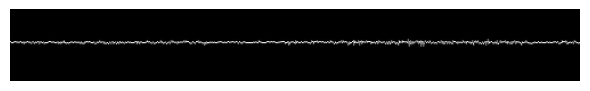

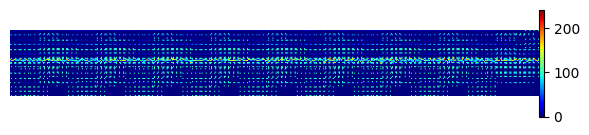

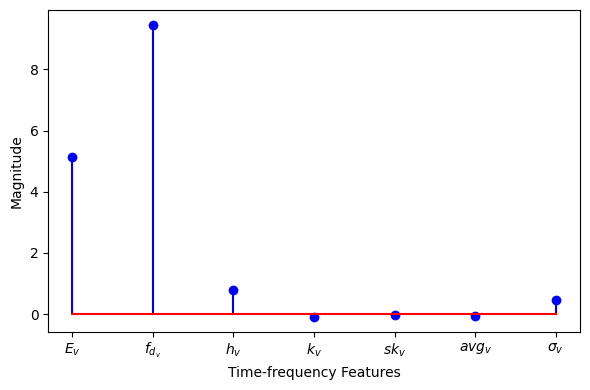

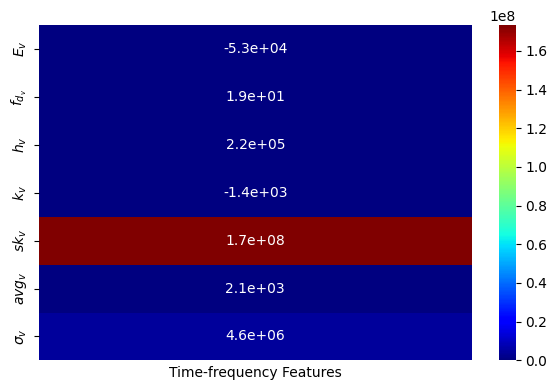

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras._tf_keras.keras.models import Model
from lrp.lrp import LRP
from multimodal import multimod_rul
from utils.preprocess import process_features, correct_dims2


x_names = [r"$E_{v}$", r"$f_{d_{v}}$", r"$h_{v}$", r"$k_{v}$", r"$sk_{v}$", r"$avg_{v}$", r"$\sigma_{v}$"]

dir = os.getcwd()
image_dir = os.path.join(dir, 'image_features')
time_dir = os.path.join(dir, 'tf_features_mm')
weights_dir = os.path.join(dir, 'model_weights')

def explain_multimodal(lrp_models, inputs, class_index=0):
    image_model, time_model, fusion_model = lrp_models
    image_input, time_input = inputs

    image_output, image_residual = image_model.forward(image_input)
    time_output, time_residual = time_model.forward(time_input)
    fusion_output, fusion_residual = fusion_model.forward([image_output.squeeze(), time_output.squeeze()])

    R = np.zeros_like(fusion_output)
    R[0, class_index] = 1  
    relevance = fusion_model.backward(R, fusion_residual)
    image_relevance = image_model.backward(relevance[0], image_residual)
    time_relevance = time_model.backward(relevance[1], time_residual)

    return image_relevance, time_relevance

# Load the trained model
model = multimod_rul(img_shape=(500, 63, 1), time_shape=(7, 1))
model.load_weights(f'{weights_dir}/xjtu_multimodal_weights.hdf5.keras')

# Define LRP models
image_branch = Model(inputs=model.input[0], outputs=model.get_layer('reshape').output)  
time_branch = Model(inputs=model.input[1], outputs=model.get_layer('tres2').output)  
fusion_branch = Model(inputs=model.get_layer('mres1ip').input, outputs=model.get_layer(index=-2).output)

lrp_image = LRP(image_branch)
lrp_time = LRP(time_branch)
lrp_fusion = LRP(fusion_branch)

bearings = {'Bearing1_1', 
            # 'Bearing1_2', 'Bearing1_3', 'Bearing1_4', 'Bearing1_5'
            }

# Process each bearing
for bearing in sorted(bearings):
    df = pd.read_csv(f'{time_dir}/{bearing}_features.csv')

    vertical_features = np.array(df['Vertical'].apply(eval).tolist())
    X_time = process_features(vertical_features)
    y_true = df['RUL'].values / np.max(df['RUL'].values)

    X_images = np.load(f'{image_dir}/{bearing}_horizontal_images.npy')
    random_index = np.random.randint(0,len(X_time))
    print(random_index)

    image_input = correct_dims2(X_images[random_index])
    time_input = correct_dims2(X_time[random_index])

    image_relevance, time_relevance = explain_multimodal([lrp_image, lrp_time, lrp_fusion], [image_input, time_input], class_index=0)

    # Normalize image and relevance
    max_val = np.max(image_input)
    image_uint8 = np.uint8(255 * (image_input[0, :, :, 0] / max_val)) if max_val > 0 else np.zeros_like(image_input, dtype=np.uint8)

    max_rel = np.max(image_relevance)
    relevance_scores_normalized = np.uint8(255 * (image_relevance[0, :, :, 0] / max_rel)) if max_rel > 0 else np.zeros_like(image_relevance[0, :, :, 0], dtype=np.uint8)

    # Overlay relevance on image
    overlay = cv2.addWeighted(image_uint8, 0.6, relevance_scores_normalized, 0.4, 0)

    # **Image Plot 1: Original Image**
    fig1 = plt.figure(figsize=(6, 4))
    plt.imshow(image_uint8, cmap='gray')
    # plt.title(f"Original Image - {bearing}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # **Image Plot 2: Relevance Overlay**
    fig2 = plt.figure(figsize=(6, 4))
    plt.imshow(overlay, cmap='jet')
    plt.colorbar(fraction=0.01, pad=0.001)  # Adjust fraction and pad for better fit
    # plt.title(f"Image Relevance - {bearing}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # **Time Plot 1: Time Features - Stem Plot**
    fig3 = plt.figure(figsize=(6, 4))
    plt.stem(x_names, time_input.squeeze(), linefmt='b-', markerfmt='bo', basefmt='r-')
    # plt.title(f"Time Features - {bearing}")
    plt.xlabel("Time-frequency Features")
    plt.ylabel("Magnitude")
    plt.tight_layout()
    plt.show()

    time_relevance = time_relevance.reshape(-1, 1)  # Shape (7, 1)
    fig4 = plt.figure(figsize=(6, 4))
    sns.heatmap(time_relevance, annot=True, cmap="jet", cbar=True, fmt='.1e', xticklabels=False, yticklabels=x_names)
    plt.xlabel("Time-frequency Features")
    # plt.title(f"Relevance Heat map- {bearing}")
    plt.tight_layout()
    plt.show()
